In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, re, glob, parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('muted')

ligan_dir = '/pylon5/mc5phpp/mtragoza/liGAN'
sys.path.append(ligan_dir)

work_dir = os.path.join(ligan_dir, 'train_molport')
os.chdir(work_dir)
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/pylon5/mc5phpp/mtragoza/liGAN/train_molport'

In [24]:
def read_err_file(err_file):
    error = None
    with open(err_file, encoding='utf-8') as f:
        for line in f:
            if not re.match('Warning.*', line) and re.match(r'.*(Error|Exception|error|fault|failed).*', line):
                error = line.rstrip()
    return error

indent = '   '
train_output_files = []
for expt_name in ['loss_types']:
    
    for job_name in reversed(sorted(os.listdir(expt_name))):
        
        err_files = []
        for err_file in os.listdir(expt_name + '/' + job_name):

            m = re.match(r'slurm-(\d+)\.err', err_file)
            if not m:
                continue
            
            job_id = int(m.group(1))
            err_file = os.path.join(expt_name, job_name, err_file)
            error = read_err_file(err_file)
            err_files.append((job_id, err_file, error))
            
        for job_id, err_file, error in sorted(err_files):
            print(err_file + '\t' + str(error)[:72])
        
        try:
            train_output_file = glob.glob('/'.join([expt_name, job_name, str(job_id), '*.training_output']))[0]
            train_output_files.append(train_output_file)
        except IndexError:
            pass
            
        print()

len(train_output_files)

loss_types/gen_e_disc_x_4/slurm-8216436.err	RuntimeError: CUDA Error: invalid configuration argument
loss_types/gen_e_disc_x_4/slurm-8353369.err	RuntimeError: CUDA Error: invalid configuration argument
loss_types/gen_e_disc_x_4/slurm-8392863.err	slurmstepd: error: *** JOB 8392863 ON gpu055 CANCELLED AT 2020-04-07T02:
loss_types/gen_e_disc_x_4/slurm-8499280.err	slurmstepd: error: *** JOB 8499280 ON gpu054 CANCELLED AT 2020-04-11T03:
loss_types/gen_e_disc_x_4/slurm-8581663.err	slurmstepd: error: *** JOB 8581663 ON gpu052 CANCELLED AT 2020-04-13T10:
loss_types/gen_e_disc_x_4/slurm-8602074.err	slurmstepd: error: *** JOB 8602074 ON gpu049 CANCELLED AT 2020-04-14T13:
loss_types/gen_e_disc_x_4/slurm-8642417.err	slurmstepd: error: *** JOB 8642417 ON gpu052 CANCELLED AT 2020-04-15T22:
loss_types/gen_e_disc_x_4/slurm-8723319.err	slurmstepd: error: *** JOB 8723319 ON gpu050 CANCELLED AT 2020-04-19T00:
loss_types/gen_e_disc_x_4/slurm-8740591.err	slurmstepd: error: *** JOB 8740591 ON gpu049 CANCELL

loss_types/gen_e_disc_w_3/slurm-8216430.err	RuntimeError: CUDA Error: invalid configuration argument
loss_types/gen_e_disc_w_3/slurm-8353363.err	slurmstepd: error: *** JOB 8353363 ON gpu054 CANCELLED AT 2020-04-04T01:
loss_types/gen_e_disc_w_3/slurm-8392857.err	slurmstepd: error: *** JOB 8392857 ON gpu054 CANCELLED AT 2020-04-06T22:
loss_types/gen_e_disc_w_3/slurm-8499274.err	slurmstepd: error: *** JOB 8499274 ON gpu050 CANCELLED AT 2020-04-10T22:
loss_types/gen_e_disc_w_3/slurm-8581657.err	slurmstepd: error: *** JOB 8581657 ON gpu053 CANCELLED AT 2020-04-12T22:
loss_types/gen_e_disc_w_3/slurm-8602068.err	slurmstepd: error: *** JOB 8602068 ON gpu052 CANCELLED AT 2020-04-14T03:
loss_types/gen_e_disc_w_3/slurm-8642411.err	slurmstepd: error: *** JOB 8642411 ON gpu053 CANCELLED AT 2020-04-15T22:
loss_types/gen_e_disc_w_3/slurm-8663253.err	slurmstepd: error: *** JOB 8663253 ON gpu053 CANCELLED AT 2020-04-16T17:
loss_types/gen_e_disc_w_3/slurm-8723313.err	slurmstepd: error: *** JOB 8723313 O

loss_types/gen_a_disc_x_4/slurm-8216426.err	RuntimeError: CUDA Error: invalid configuration argument
loss_types/gen_a_disc_x_4/slurm-8353359.err	slurmstepd: error: *** JOB 8353359 ON gpu052 CANCELLED AT 2020-04-04T01:
loss_types/gen_a_disc_x_4/slurm-8392853.err	ValueError: Missing molecular data in line:
loss_types/gen_a_disc_x_4/slurm-8499270.err	slurmstepd: error: *** JOB 8499270 ON gpu057 CANCELLED AT 2020-04-10T07:
loss_types/gen_a_disc_x_4/slurm-8581653.err	slurmstepd: error: *** JOB 8581653 ON gpu052 CANCELLED AT 2020-04-12T22:
loss_types/gen_a_disc_x_4/slurm-8602064.err	slurmstepd: error: *** JOB 8602064 ON gpu051 CANCELLED AT 2020-04-14T01:
loss_types/gen_a_disc_x_4/slurm-8642407.err	slurmstepd: error: *** JOB 8642407 ON gpu050 CANCELLED AT 2020-04-15T22:
loss_types/gen_a_disc_x_4/slurm-8663249.err	slurmstepd: error: *** JOB 8663249 ON gpu050 CANCELLED AT 2020-04-16T23:
loss_types/gen_a_disc_x_4/slurm-8723309.err	slurmstepd: error: *** JOB 8723309 ON gpu050 CANCELLED AT 2020-04

loss_types/gen_a_disc_x_0/slurm-8091335.err	FileNotFoundError: [Errno 2] No such file or directory: 'data_48_0.5.mod
loss_types/gen_a_disc_x_0/slurm-8216422.err	RuntimeError: CUDA Error: invalid configuration argument
loss_types/gen_a_disc_x_0/slurm-8353355.err	slurmstepd: error: *** JOB 8353355 ON gpu051 CANCELLED AT 2020-04-04T01:
loss_types/gen_a_disc_x_0/slurm-8392849.err	slurmstepd: error: *** JOB 8392849 ON gpu056 CANCELLED AT 2020-04-06T09:
loss_types/gen_a_disc_x_0/slurm-8499266.err	slurmstepd: error: *** JOB 8499266 ON gpu055 CANCELLED AT 2020-04-10T04:
loss_types/gen_a_disc_x_0/slurm-8581649.err	slurmstepd: error: *** JOB 8581649 ON gpu057 CANCELLED AT 2020-04-12T22:
loss_types/gen_a_disc_x_0/slurm-8602060.err	slurmstepd: error: *** JOB 8602060 ON gpu050 CANCELLED AT 2020-04-14T01:
loss_types/gen_a_disc_x_0/slurm-8642403.err	slurmstepd: error: *** JOB 8642403 ON gpu054 CANCELLED AT 2020-04-15T10:
loss_types/gen_a_disc_x_0/slurm-8663245.err	slurmstepd: error: *** JOB 8663245 O

loss_types/gen_a_disc_w_1/slurm-8216418.err	RuntimeError: CUDA Error: invalid configuration argument
loss_types/gen_a_disc_w_1/slurm-8353351.err	slurmstepd: error: *** JOB 8353351 ON gpu050 CANCELLED AT 2020-04-04T01:
loss_types/gen_a_disc_w_1/slurm-8392845.err	slurmstepd: error: *** JOB 8392845 ON gpu054 CANCELLED AT 2020-04-06T09:
loss_types/gen_a_disc_w_1/slurm-8499262.err	ValueError: Missing molecular data in line:
loss_types/gen_a_disc_w_1/slurm-8581645.err	slurmstepd: error: *** JOB 8581645 ON gpu055 CANCELLED AT 2020-04-12T22:
loss_types/gen_a_disc_w_1/slurm-8602056.err	slurmstepd: error: *** JOB 8602056 ON gpu052 CANCELLED AT 2020-04-14T01:
loss_types/gen_a_disc_w_1/slurm-8642399.err	slurmstepd: error: *** JOB 8642399 ON gpu053 CANCELLED AT 2020-04-15T10:
loss_types/gen_a_disc_w_1/slurm-8663241.err	slurmstepd: error: *** JOB 8663241 ON gpu051 CANCELLED AT 2020-04-16T15:
loss_types/gen_a_disc_w_1/slurm-8723300.err	slurmstepd: error: *** JOB 8723300 ON gpu052 CANCELLED AT 2020-04

loss_types/ae_disc_x_1/slurm-8581640.err	train.py: error: argument --cont_iter: expected one argument
loss_types/ae_disc_x_1/slurm-8602051.err	FileNotFoundError: [Errno 2] No such file or directory: '../../../models
loss_types/ae_disc_x_1/slurm-8631255.err	slurmstepd: error: *** JOB 8631255 ON gpu054 CANCELLED AT 2020-04-14T22:
loss_types/ae_disc_x_1/slurm-8642394.err	slurmstepd: error: *** JOB 8642394 ON gpu052 CANCELLED AT 2020-04-15T10:
loss_types/ae_disc_x_1/slurm-8663236.err	slurmstepd: error: *** JOB 8663236 ON gpu050 CANCELLED AT 2020-04-16T11:
loss_types/ae_disc_x_1/slurm-8696109.err	slurmstepd: error: *** JOB 8696109 ON gpu054 CANCELLED AT 2020-04-17T13:
loss_types/ae_disc_x_1/slurm-8723295.err	slurmstepd: error: *** JOB 8723295 ON gpu050 CANCELLED AT 2020-04-18T06:
loss_types/ae_disc_x_1/slurm-8740568.err	slurmstepd: error: *** JOB 8740568 ON gpu051 CANCELLED AT 2020-04-19T17:
loss_types/ae_disc_x_1/slurm-8754091.err	slurmstepd: error: *** JOB 8754091 ON gpu052 CANCELLED AT 2

loss_types/ae_disc_w_0/slurm-8581634.err	train.py: error: argument --cont_iter: expected one argument
loss_types/ae_disc_w_0/slurm-8602045.err	FileNotFoundError: [Errno 2] No such file or directory: '../../../models
loss_types/ae_disc_w_0/slurm-8631249.err	slurmstepd: error: *** JOB 8631249 ON gpu050 CANCELLED AT 2020-04-14T22:
loss_types/ae_disc_w_0/slurm-8642388.err	slurmstepd: error: *** JOB 8642388 ON gpu050 CANCELLED AT 2020-04-15T10:
loss_types/ae_disc_w_0/slurm-8663230.err	slurmstepd: error: *** JOB 8663230 ON gpu049 CANCELLED AT 2020-04-16T09:
loss_types/ae_disc_w_0/slurm-8696103.err	slurmstepd: error: *** JOB 8696103 ON gpu051 CANCELLED AT 2020-04-17T10:
loss_types/ae_disc_w_0/slurm-8723289.err	slurmstepd: error: *** JOB 8723289 ON gpu055 CANCELLED AT 2020-04-18T06:
loss_types/ae_disc_w_0/slurm-8740562.err	slurmstepd: error: *** JOB 8740562 ON gpu055 CANCELLED AT 2020-04-19T08:
loss_types/ae_disc_w_0/slurm-8754085.err	slurmstepd: error: *** JOB 8754085 ON gpu054 CANCELLED AT 2

30

In [25]:
vae_name_format = 'gen_{gen_loss_type}_disc_{disc_loss_type}_{random_seed}'
ae_name_format  = 'ae_disc_{disc_loss_type}_{random_seed}'

train_job_dfs = []
for train_output_file in train_output_files:
    try:
        train_job_df = pd.read_csv(train_output_file, sep=' ')
    except Exception as e:
        print(train_output_file, e, file=sys.stderr)
        continue
    
    expt_name, job_name, job_id, _ = train_output_file.split('/')
    out_file = '/'.join([expt_name, job_name, 'slurm-{}.out'.format(job_id)])
    err_file = '/'.join([expt_name, job_name, 'slurm-{}.err'.format(job_id)])
    
    train_job_df['expt_name'] = expt_name
    train_job_df['job_name'] = job_name
    train_job_df['model_name'] = job_name.rsplit('_', 1)[0]
    train_job_df['job_id'] = int(job_id)
    train_job_df['out_file'] = out_file
    train_job_df['err_file'] = err_file
    
    # get params from job_name
    try:
        job_params = parse.parse(vae_name_format, job_name).named
        variational = True
    except:
        job_params = parse.parse(ae_name_format, job_name).named
        variational = False
    
    for param, value in job_params.items():
        train_job_df[param] = value
        
    train_job_df['variational'] = variational
    if not variational:
        train_job_df['gen_loss_type'] = 'e'
    
    # get error from err_file
    train_job_df['job_error'] = read_err_file(err_file)
    
    train_job_df = train_job_df.rename(columns=dict({'test_data': 'phase'}))
    
    train_job_dfs.append(train_job_df)

train_df = pd.concat(train_job_dfs)
train_df.set_index(['expt_name', 'job_name', 'job_id'])

loss_types/gen_a_disc_w_2/8916170/gen_a_disc_w_2.molportFULL_rand_.2.0.training_output No columns to parse from file


disc_grad_norm  disc_iter  disc_log_loss  \
expt_name  job_name       job_id                                              
loss_types gen_e_disc_x_4 8916187        1.000000        0.0       0.697052   
                          8916187        1.000000        0.0       0.697082   
                          8916187        1.000000      100.0       0.681753   
                          8916187        1.000000      100.0       0.681730   
                          8916187        1.000000      200.0       0.656574   
                          8916187        1.000000      200.0       0.658352   
                          8916187        1.000000      300.0       0.626412   
                          8916187        1.000000      300.0       0.626694   
                          8916187        1.000000      400.0       0.574876   
                          8916187        1.000000      400.0       0.579249   
                          8916187        1.000000      500.0       0.521994   
                          8916187        1.000000      500.0       0.507566   
                          8916187        1.000000      600.0       0.476447   
                          8916187        1.000000      600.0       0.464763   
                          8916187        1.000000      700.0       0.527278   
                          8916187        1.000000      700.0       0.525265   
                          8916187        1.000000      800.0       0.509067   
                          8916187        0.999315      800.0       0.517911   
                          8916187        0.728607      900.0       0.698904   
                          8916187        0.722714      900.0       0.696300   
                          8916187        0.663642     1000.0       0.770530   
                          8916187        0.722439     1000.0       0.811008   
                          8916187        0.613895     1100.0       0.754316   
                          8916187        0.647795     1100.0       0.794614   
                          8916187        0.629146     1200.0       0.715383   
                          8916187        0.619540     1200.0       0.744308   
                          8916187        0.722207     1300.0       0.591900   
                          8916187        0.615121     1300.0       0.585872   
                          8916187        0.680421     1400.0       0.685665   
                          8916187        0.678515     1400.0       0.621312   
...                                           ...        ...            ...   
           ae_disc_w_0    8916158        1.000000    54000.0            NaN   
                          8916158        1.000000    54000.0            NaN   
                          8916158        1.000000    54100.0            NaN   
                          8916158        1.000000    54100.0            NaN   
                          8916158        1.000000    54200.0            NaN   
                          8916158        1.000000    54200.0            NaN   
                          8916158        1.000000    54300.0            NaN   
                          8916158        1.000000    54300.0            NaN   
                          8916158        1.000000    54400.0            NaN   
                          8916158        1.000000    54400.0            NaN   
                          8916158        1.000000    54500.0            NaN   
                          8916158        1.000000    54500.0            NaN   
                          8916158        1.000000    54600.0            NaN   
                          8916158        1.000000    54600.0            NaN   
                          8916158        1.000000    54700.0            NaN   
                          8916158        1.000000    54700.0            NaN   
                          8916158        1.000000    54800.0            NaN   
                          8916158        1.000000    54800.0            NaN   
      

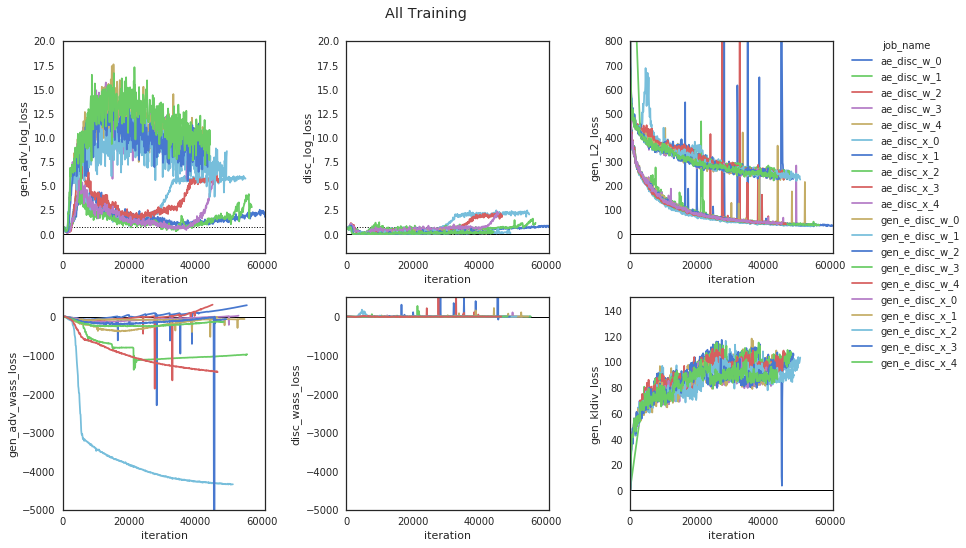

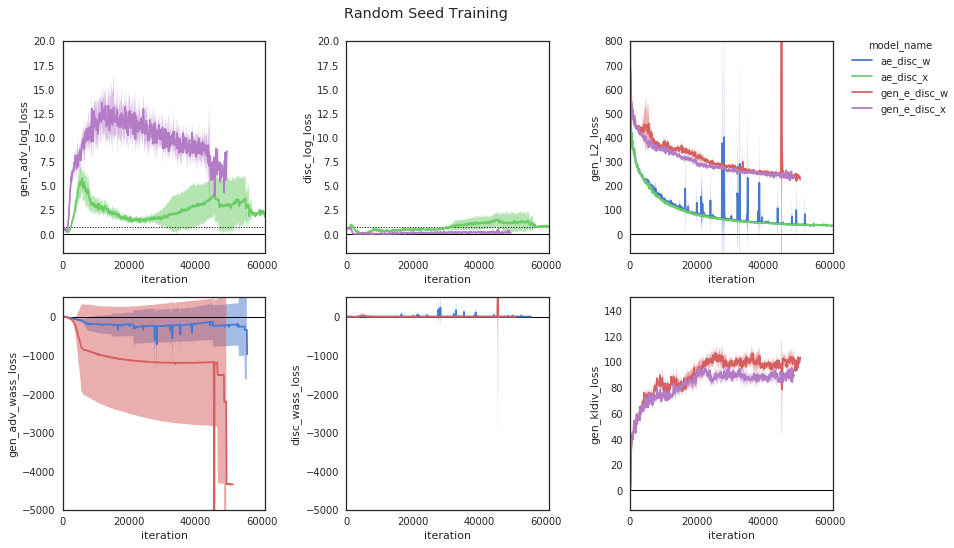

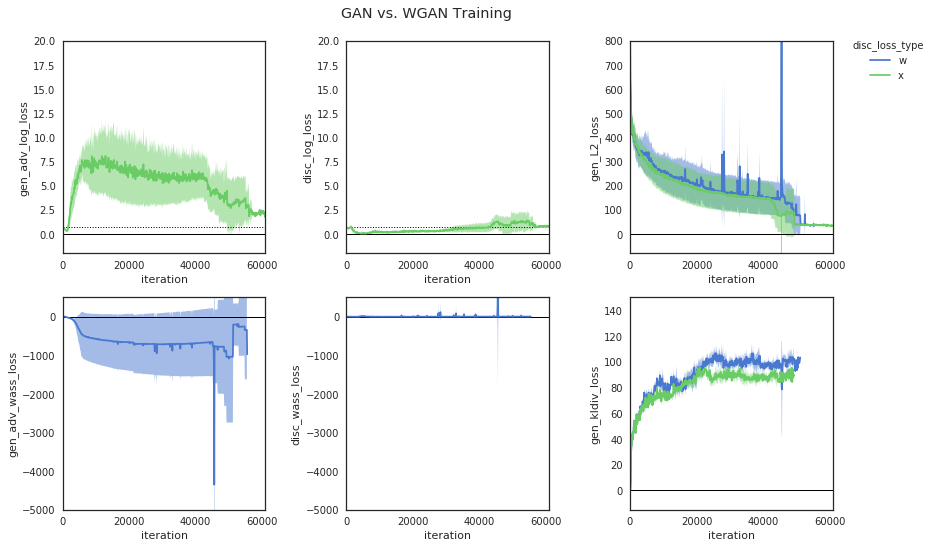

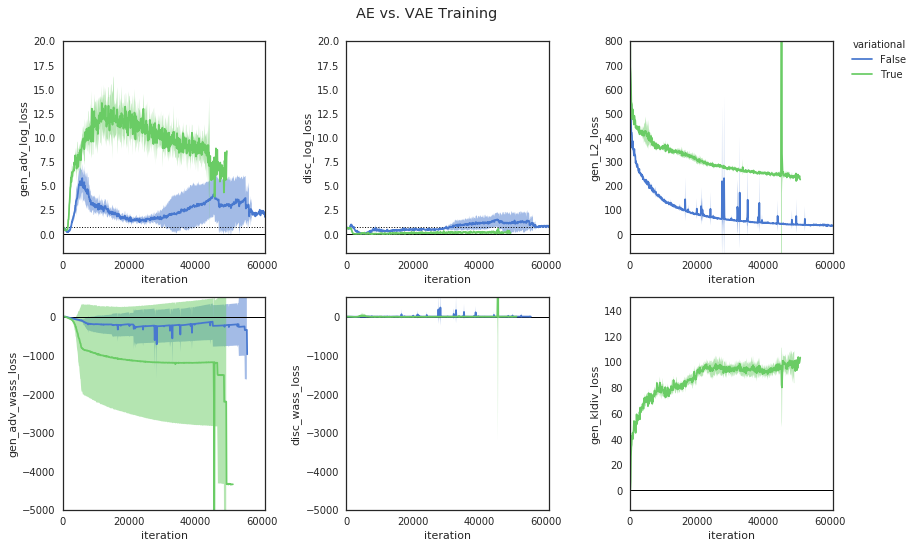

In [26]:
from collections import OrderedDict
from results import plot_lines

set_ylim = True
ylim = OrderedDict([
    ('gen_adv_log_loss',  (-2, 20)),
    ('disc_log_loss',     (-2, 20)),
    ('gen_L2_loss',       (-80, 800)),
    
    ('gen_adv_wass_loss', (-5000, 500)),
    ('disc_wass_loss',    (-5000, 500)),
    ('gen_kldiv_loss',    (-15, 150))
])
y = ylim.keys()

if not set_ylim:
    ylim = None

plot_df = train_df[(train_df['phase'] == 'train') & \
                   (train_df['gen_loss_type'] == 'e')]

fig = plot_lines('train_molport_lines.png', plot_df,
                 x='iteration', y=y,  hue='job_name',
                 n_cols=3, height=4, width=4, ylim=ylim,
                 title='All Training')

fig = plot_lines('train_molport_lines_random_seed.png', plot_df,
                 x='iteration', y=y,  hue='model_name',
                 n_cols=3, height=4, width=4, ylim=ylim,
                 title='Random Seed Training')

fig = plot_lines('train_molport_lines_GAN_vs_WGAN.png', plot_df,
                 x='iteration', y=y,  hue='disc_loss_type',
                 n_cols=3, height=4, width=4, ylim=ylim,
                 title='GAN vs. WGAN Training')

fig = plot_lines('train_molport_lines_AE_vs_VAE.png', plot_df,
                 x='iteration', y=y,  hue='variational',
                 n_cols=3, height=4, width=4, ylim=ylim,
                 title='AE vs. VAE Training')

In [6]:
indent = '    '
gen_metric_files = []

for expt_name in ['fit_pdbbind']:
    print(expt_name)
    
    for job_name in os.listdir(expt_name):
        
        if '.' in job_name: # skip files
            continue

        print(indent + job_name)
        
        job_ids = []
        for err_file in os.listdir(expt_name + '/' + job_name):
            
            m = re.match(r'slurm-(\d+)_(\d+)\.err', err_file)
            if not m:
                continue
                
            print(2*indent + err_file)
                
            job_id = int(m.group(1))
            array_idx = int(m.group(2))
            
            if array_idx >= 300:
                continue
            
            if job_id not in job_ids:
                job_ids.append(job_id)
                
        job_id = sorted(job_ids)[-1]
        
        gen_metric_pat = expt_name + '/' + job_name + '/' + str(job_id) + '/*.gen_metrics'
        gen_metric_files.extend(glob.glob(gen_metric_pat))
        print()

len(gen_metric_files)

fit_pdbbind
    gen_a_disc_x_0_100000_
        slurm-8110951_1.err
        slurm-8114899_1472.err
        slurm-8114899_416.err
        slurm-8114899_864.err
        slurm-8114899_1013.err
        slurm-8243471_566.err
        slurm-8114899_701.err
        slurm-8166264_3.err
        slurm-8114899_21.err
        slurm-8114899_360.err
        slurm-8243471_671.err
        slurm-8114899_1304.err
        slurm-8114899_659.err
        slurm-8243471_729.err
        slurm-8114899_238.err
        slurm-8114899_688.err
        slurm-8114899_818.err
        slurm-8188446_227.err
        slurm-8181556_193.err
        slurm-8114899_1378.err
        slurm-8181556_142.err
        slurm-8166264_82.err
        slurm-8114899_625.err
        slurm-8208254_440.err
        slurm-8114899_182.err
        slurm-8114899_244.err
        slurm-8114899_991.err
        slurm-8114899_1220.err
        slurm-8114899_295.err
        slurm-8114899_940.err
        slurm-8114899_532.err
        slurm-8114899_1137.err
 

        slurm-8166264_12.err
        slurm-8114899_1176.err
        slurm-8114899_573.err
        slurm-8114899_901.err
        slurm-8243471_714.err
        slurm-8114899_1261.err
        slurm-8114899_205.err
        slurm-8114899_664.err
        slurm-8208254_401.err
        slurm-8181556_104.err
        slurm-8114899_1499.err
        slurm-8114899_1029.err
        slurm-8114899_1448.err
        slurm-8188446_261.err
        slurm-8166264_15.err
        slurm-8114899_115.err
        slurm-8208254_370.err
        slurm-8114899_1171.err
        slurm-8114899_906.err
        slurm-8114899_574.err
        slurm-8114899_1266.err
        slurm-8243471_713.err
        slurm-8114899_202.err
        slurm-8114899_663.err
        slurm-8208254_406.err
        slurm-8243471_637.err
        slurm-8114899_1342.err
        slurm-8181556_178.err
        slurm-8114899_326.err
        slurm-8114899_481.err
        slurm-8114899_67.err
        slurm-8114899_1084.err
        slurm-8114899_747.err
    


    gen_e_disc_w_0_100000_r
        slurm-8166270_76.err
        slurm-8181562_132.err
        slurm-8208260_430.err
        slurm-8208260_397.err
        slurm-8208260_346.err
        slurm-8188452_260.err
        slurm-8181562_198.err
        slurm-8181562_149.err
        slurm-8188452_267.err
        slurm-8166270_71.err
        slurm-8181562_135.err
        slurm-8208260_390.err
        slurm-8208260_437.err
        slurm-8208260_341.err
        slurm-8181562_196.err
        slurm-8181562_147.err
        slurm-8208260_445.err
        slurm-8188452_269.err
        slurm-8208260_494.err
        slurm-8208260_333.err
        slurm-8208260_439.err
        slurm-8188452_215.err
        slurm-8166270_78.err
        slurm-8208260_399.err
        slurm-8188452_212.err
        slurm-8208260_348.err
        slurm-8181562_191.err
        slurm-8181562_140.err
        slurm-8208260_442.err
        slurm-8208260_334.err
        slurm-8208260_493.err
        slurm-8181562_109.err
        slurm-


    gen_e_disc_w_0_100000_rc
        slurm-8188453_252.err
        slurm-8208261_308.err
        slurm-8166271_60.err
        slurm-8188453_283.err
        slurm-8208261_402.err
        slurm-8208261_374.err
        slurm-8181563_107.err
        slurm-8188453_229.err
        slurm-8208261_405.err
        slurm-8208261_373.err
        slurm-8188453_255.err
        slurm-8208261_479.err
        slurm-8188453_284.err
        slurm-8166271_67.err
        slurm-8181563_109.err
        slurm-8188453_227.err
        slurm-8166271_15.err
        slurm-8181563_175.err
        slurm-8208261_477.err
        slurm-8208261_301.err
        slurm-8166271_69.err
        slurm-8181563_172.err
        slurm-8208261_470.err
        slurm-8208261_306.err
        slurm-8188453_220.err
        slurm-8166271_12.err
        slurm-8181563_147.err
        slurm-8166271_2.err
        slurm-8181563_196.err
        slurm-8208261_494.err
        slurm-8208261_333.err
        slurm-8208261_445.err
        slurm-818


    gen_e_disc_x_0_100000_rc
        slurm-8208265_447.err
        slurm-8208265_331.err
        slurm-8208265_496.err
        slurm-8181567_194.err
        slurm-8181567_145.err
        slurm-8166275_40.err
        slurm-8188457_217.err
        slurm-8166275_91.err
        slurm-8181567_139.err
        slurm-8166275_47.err
        slurm-8188457_210.err
        slurm-8166275_96.err
        slurm-8208265_440.err
        slurm-8208265_491.err
        slurm-8208265_336.err
        slurm-8181567_193.err
        slurm-8181567_142.err
        slurm-8166275_49.err
        slurm-8208265_395.err
        slurm-8208265_432.err
        slurm-8208265_344.err
        slurm-8166275_98.err
        slurm-8181567_130.err
        slurm-8166275_35.err
        slurm-8188457_262.err
        slurm-8208265_338.err
        slurm-8208265_449.err
        slurm-8166275_32.err
        slurm-8188457_265.err
        slurm-8208265_498.err
        slurm-8208265_435.err
        slurm-8208265_392.err
        slurm-8188


    gen_e_disc_w_0_100000_
        slurm-8208258_357.err
        slurm-8208258_386.err
        slurm-8208258_421.err
        slurm-8181560_135.err
        slurm-8166268_71.err
        slurm-8188450_267.err
        slurm-8181560_198.err
        slurm-8181560_149.err
        slurm-8188450_260.err
        slurm-8208258_350.err
        slurm-8208258_426.err
        slurm-8208258_381.err
        slurm-8181560_132.err
        slurm-8166268_76.err
        slurm-8181560_191.err
        slurm-8208258_322.err
        slurm-8208258_485.err
        slurm-8208258_454.err
        slurm-8181560_140.err
        slurm-8188450_212.err
        slurm-8208258_428.err
        slurm-8166268_78.err
        slurm-8188450_215.err
        slurm-8208258_359.err
        slurm-8208258_388.err
        slurm-8188450_269.err
        slurm-8181560_196.err
        slurm-8208258_482.err
        slurm-8208258_325.err
        slurm-8208258_453.err
        slurm-8181560_147.err
        slurm-8188450_220.err
        slurm-8


    gen_a_disc_x_0_100000_r
        slurm-8208256_477.err
        slurm-8208256_301.err
        slurm-8181558_172.err
        slurm-8166266_74.err
        slurm-8188448_217.err
        slurm-8243473_551.err
        slurm-8243473_697.err
        slurm-8243473_646.err
        slurm-8243473_580.err
        slurm-8243473_719.err
        slurm-8181558_175.err
        slurm-8166266_73.err
        slurm-8188448_210.err
        slurm-8243473_556.err
        slurm-8243473_690.err
        slurm-8243473_641.err
        slurm-8243473_587.err
        slurm-8181558_109.err
        slurm-8208256_470.err
        slurm-8208256_306.err
        slurm-8243473_717.err
        slurm-8208256_402.err
        slurm-8208256_374.err
        slurm-8243473_558.err
        slurm-8243473_589.err
        slurm-8181558_107.err
        slurm-8208256_308.err
        slurm-8188448_262.err
        slurm-8243473_524.err
        slurm-8243473_633.err
        slurm-8208256_479.err
        slurm-8188448_265.err
        slurm


    gen_e_disc_x_0_100000_
        slurm-8188454_287.err
        slurm-8188454_256.err
        slurm-8181564_178.err
        slurm-8166272_20.err
        slurm-8208262_370.err
        slurm-8208262_406.err
        slurm-8181564_104.err
        slurm-8181564_103.err
        slurm-8188454_280.err
        slurm-8188454_251.err
        slurm-8166272_27.err
        slurm-8208262_377.err
        slurm-8208262_401.err
        slurm-8188454_223.err
        slurm-8166272_55.err
        slurm-8208262_305.err
        slurm-8208262_473.err
        slurm-8166272_84.err
        slurm-8166272_5.err
        slurm-8166272_29.err
        slurm-8181564_171.err
        slurm-8208262_379.err
        slurm-8166272_2.err
        slurm-8188454_289.err
        slurm-8188454_258.err
        slurm-8188454_300.err
        slurm-8181564_176.err
        slurm-8208262_408.err
        slurm-8188454_224.err
        slurm-8166272_52.err
        slurm-8208262_302.err
        slurm-8208262_474.err
        slurm-8166272_


    gen_e_disc_x_0_100000_c
        slurm-8188455_296.err
        slurm-8188455_247.err
        slurm-8181565_169.err
        slurm-8208263_361.err
        slurm-8208263_417.err
        slurm-8181565_115.err
        slurm-8166273_79.err
        slurm-8181565_112.err
        slurm-8188455_291.err
        slurm-8188455_240.err
        slurm-8208263_366.err
        slurm-8208263_410.err
        slurm-8188455_232.err
        slurm-8166273_77.err
        slurm-8208263_314.err
        slurm-8208263_462.err
        slurm-8181565_160.err
        slurm-8208263_368.err
        slurm-8188455_298.err
        slurm-8188455_249.err
        slurm-8181565_167.err
        slurm-8208263_419.err
        slurm-8188455_235.err
        slurm-8166273_70.err
        slurm-8208263_313.err
        slurm-8208263_465.err
        slurm-8166273_39.err
        slurm-8181565_183.err
        slurm-8181565_152.err
        slurm-8166273_45.err
        slurm-8166273_94.err
        slurm-8166273_1.err
        slurm-82082


    gen_a_disc_w_0_100000_
        slurm-8181552_125.err
        slurm-8114894_1819.err
        slurm-8188442_291.err
        slurm-8243467_630.err
        slurm-8114894_158.err
        slurm-8114894_539.err
        slurm-8114894_94.err
        slurm-8114894_45.err
        slurm-8166260_8.err
        slurm-8243467_527.err
        slurm-8114894_2669.err
        slurm-8114894_2208.err
        slurm-8114894_189.err
        slurm-8188442_240.err
        slurm-8114894_1624.err
        slurm-8114894_1183.err
        slurm-8208250_351.err
        slurm-8114894_2731.err
        slurm-8114894_2096.err
        slurm-8114894_317.err
        slurm-8114894_1245.err
        slurm-8114894_1990.err
        slurm-8114894_2350.err
        slurm-8114894_776.err
        slurm-8114894_2381.err
        slurm-8114894_2426.err
        slurm-8114894_1294.err
        slurm-8114894_1941.err
        slurm-8114894_1533.err
        slurm-8114894_813.err
        slurm-8114894_461.err
        slurm-8114894_2047.err


        slurm-8114894_1053.err
        slurm-8243467_669.err
        slurm-8114894_101.err
        slurm-8114894_2280.err
        slurm-8114894_2527.err
        slurm-8114894_1395.err
        slurm-8114894_1840.err
        slurm-8114894_1432.err
        slurm-8188442_219.err
        slurm-8114894_1344.err
        slurm-8114894_1891.err
        slurm-8114894_2251.err
        slurm-8114894_677.err
        slurm-8114894_1725.err
        slurm-8114894_1082.err
        slurm-8114894_2630.err
        slurm-8114894_2197.err
        slurm-8114894_216.err
        slurm-8114894_409.err
        slurm-8114894_2788.err
        slurm-8243467_700.err
        slurm-8114894_1929.err
        slurm-8114894_2338.err
        slurm-8208250_339.err
        slurm-8114894_2759.err
        slurm-8114894_2260.err
        slurm-8114894_646.err
        slurm-8243467_689.err
        slurm-8188442_228.err
        slurm-8114894_1375.err
        slurm-8114894_2601.err
        slurm-8114894_580.err
        slurm-811489

        slurm-8114896_2123.err
        slurm-8114896_2684.err
        slurm-8114896_1036.err
        slurm-8114896_1791.err
        slurm-8181553_135.err
        slurm-8188443_281.err
        slurm-8114896_2542.err
        slurm-8114896_919.err
        slurm-8114896_1457.err
        slurm-8114896_1825.err
        slurm-8243468_672.err
        slurm-8114896_394.err
        slurm-8114896_841.err
        slurm-8114896_433.err
        slurm-8114896_76.err
        slurm-8208251_437.err
        slurm-8208251_390.err
        slurm-8208251_341.err
        slurm-8114896_1279.err
        slurm-8114896_345.err
        slurm-8114896_890.err
        slurm-8114896_724.err
        slurm-8114896_1618.err
        slurm-8114896_2248.err
        slurm-8114896_1888.err
        slurm-8114896_261.err
        slurm-8114896_2629.err
        slurm-8114896_600.err
        slurm-8181553_198.err
        slurm-8243468_519.err
        slurm-8181553_149.err
        slurm-8114896_176.err
        slurm-8114896_517.err


    gen_a_disc_x_0_100000_rc
        slurm-8243474_644.err
        slurm-8243474_582.err
        slurm-8243474_553.err
        slurm-8181559_125.err
        slurm-8188449_291.err
        slurm-8166267_14.err
        slurm-8188449_240.err
        slurm-8166267_8.err
        slurm-8243474_638.err
        slurm-8181559_159.err
        slurm-8208257_387.err
        slurm-8208257_420.err
        slurm-8166267_68.err
        slurm-8208257_356.err
        slurm-8181559_188.err
        slurm-8243474_528.err
        slurm-8208257_427.err
        slurm-8208257_380.err
        slurm-8208257_351.err
        slurm-8243474_643.err
        slurm-8243474_585.err
        slurm-8243474_554.err
        slurm-8188449_296.err
        slurm-8181559_122.err
        slurm-8166267_13.err
        slurm-8188449_247.err
        slurm-8243474_631.err
        slurm-8243474_526.err
        slurm-8181559_150.err
        slurm-8166267_61.err
        slurm-8208257_429.err
        slurm-8188449_235.err
        slurm-81


    gen_a_disc_w_0_100000_rc
        slurm-8243470_509.err
        slurm-8114898_2432.err
        slurm-8114898_2395.err
        slurm-8114898_1955.err
        slurm-8114898_1527.err
        slurm-8114898_1280.err
        slurm-8114898_2053.err
        slurm-8114898_479.err
        slurm-8114898_1146.err
        slurm-8114898_1197.err
        slurm-8114898_1630.err
        slurm-8114898_2082.err
        slurm-8114898_2725.err
        slurm-8114898_1984.err
        slurm-8114898_1251.err
        slurm-8114898_2344.err
        slurm-8243470_746.err
        slurm-8114898_982.err
        slurm-8114898_1768.err
        slurm-8114898_257.err
        slurm-8208253_370.err
        slurm-8181555_178.err
        slurm-8114898_16.err
        slurm-8114898_191.err
        slurm-8114898_1309.err
        slurm-8114898_636.err
        slurm-8114898_140.err
        slurm-8208253_406.err
        slurm-8114898_953.err
        slurm-8114898_521.err
        slurm-8114898_286.err
        slurm-8114898_192

        slurm-8114898_1825.err
        slurm-8166263_84.err
        slurm-8181555_181.err
        slurm-8188445_235.err
        slurm-8114898_2542.err
        slurm-8208253_389.err
        slurm-8114898_1791.err
        slurm-8114898_509.err
        slurm-8114898_1036.err
        slurm-8114898_2684.err
        slurm-8114898_2123.err
        slurm-8243470_521.err
        slurm-8114898_797.err
        slurm-8114898_451.err
        slurm-8114898_823.err
        slurm-8114898_1618.err
        slurm-8114898_327.err
        slurm-8114898_480.err
        slurm-8243470_636.err
        slurm-8114898_1279.err
        slurm-8114898_746.err
        slurm-8114898_203.err
        slurm-8208253_483.err
        slurm-8208253_324.err
        slurm-8243470_712.err
        slurm-8114898_2629.err
        slurm-8166263_29.err
        slurm-8114898_42.err
        slurm-8114898_1888.err
        slurm-8114898_662.err
        slurm-8114898_2248.err
        slurm-8188445_298.err
        slurm-8188445_249.err
  

        slurm-8114897_2087.err
        slurm-8114897_712.err
        slurm-8114897_1370.err
        slurm-8114897_2265.err
        slurm-8114897_1711.err
        slurm-8114897_373.err
        slurm-8114897_22.err
        slurm-8114897_2604.err
        slurm-8114897_2172.err
        slurm-8114897_405.err
        slurm-8114897_877.err
        slurm-8114897_1067.err
        slurm-8114897_2513.err
        slurm-8114897_1874.err
        slurm-8114897_1406.err
        slurm-8181554_187.err
        slurm-8188444_233.err
        slurm-8114897_1698.err
        slurm-8243469_644.err
        slurm-8243469_582.err
        slurm-8208252_428.err
        slurm-8243469_553.err
        slurm-8114897_1228.err
        slurm-8243469_695.err
        slurm-8114897_1649.err
        slurm-8181554_156.err
        slurm-8166262_44.err
        slurm-8114897_1789.err
        slurm-8114897_1758.err
        slurm-8166262_95.err
        slurm-8114897_1339.err
        slurm-8114897_1600.err
        slurm-8114897_262.


    gen_a_disc_x_0_100000_c
        slurm-8243472_605.err
        slurm-8208255_461.err
        slurm-8208255_317.err
        slurm-8243472_512.err
        slurm-8188447_206.err
        slurm-8181557_163.err
        slurm-8166265_6.err
        slurm-8166265_62.err
        slurm-8243472_679.err
        slurm-8243472_721.err
        slurm-8166265_65.err
        slurm-8243472_569.err
        slurm-8181557_118.err
        slurm-8243472_726.err
        slurm-8166265_19.err
        slurm-8243472_602.err
        slurm-8208255_466.err
        slurm-8208255_310.err
        slurm-8243472_515.err
        slurm-8188447_201.err
        slurm-8181557_164.err
        slurm-8166265_1.err
        slurm-8243472_670.err
        slurm-8208255_414.err
        slurm-8208255_362.err
        slurm-8243472_567.err
        slurm-8188447_273.err
        slurm-8181557_116.err
        slurm-8243472_728.err
        slurm-8166265_17.err
        slurm-8208255_468.err
        slurm-8166265_10.err
        slurm-820825

1200

In [7]:
name_format = 'gen_{gen_loss_type}_disc_{disc_loss_type}_{random_seed}_{iteration}_'

fit_job_dfs = []
for gen_metric_file in gen_metric_files:
    try:
        fit_job_df = pd.read_csv(gen_metric_file, sep=' ')
    except Exception as e:
        print(gen_metric_file, e, file=sys.stderr)
        continue
    
    expt_name, job_name, job_id, _ = gen_metric_file.split('/')
    #out_file = '/'.join([expt_name, job_name, 'slurm-{}.out'.format(job_id)])
    #err_file = '/'.join([expt_name, job_name, 'slurm-{}.err'.format(job_id)])
    
    fit_job_df['expt_name'] = expt_name
    fit_job_df['job_name'] = job_name
    fit_job_df['job_id'] = int(job_id)
    #fit_job_df['out_file'] = out_file
    #fit_job_df['err_file'] = err_file
    
    # get params from job_name
    job_name, fit_options = job_name.rsplit('_', 1)
    job_params = parse.parse(name_format, job_name+'_').named
    for param, value in job_params.items():
        fit_job_df[param] = value
        
    fit_job_df['random_rotation'] = 'r' in fit_options
    fit_job_df['constrain_types'] = 'c' in fit_options
    
    # get error from err_file
    #fit_job_df['job_error'] = read_err_file(err_file)
    
    fit_job_dfs.append(fit_job_df)

fit_df = pd.concat(fit_job_dfs)

In [7]:
fit_df.columns

Index(['lig_name', 'sample_idx', 'lig_norm', 'lig_gen_norm', 'lig_gen_loss',
       'lig_var', 'lig_gen_var', 'lig_fit_loss', 'lig_gen_fit_loss',
       'lig_n_atoms', 'lig_fit_n_atoms', 'lig_gen_fit_n_atoms', 'lig_radius',
       'lig_fit_radius', 'lig_gen_fit_radius', 'lig_fit_type_diff',
       'lig_gen_fit_type_diff', 'lig_fit_RMSD', 'lig_gen_fit_RMSD',
       'lig_fit_time', 'lig_gen_fit_time', 'lig_fit_error',
       'lig_gen_fit_error', 'lig_fit_n_frags', 'lig_gen_fit_n_frags',
       'expt_name', 'job_name', 'job_id', 'gen_loss_type', 'disc_loss_type',
       'random_seed', 'iteration', 'random_rotation', 'constrain_types'],
      dtype='object')

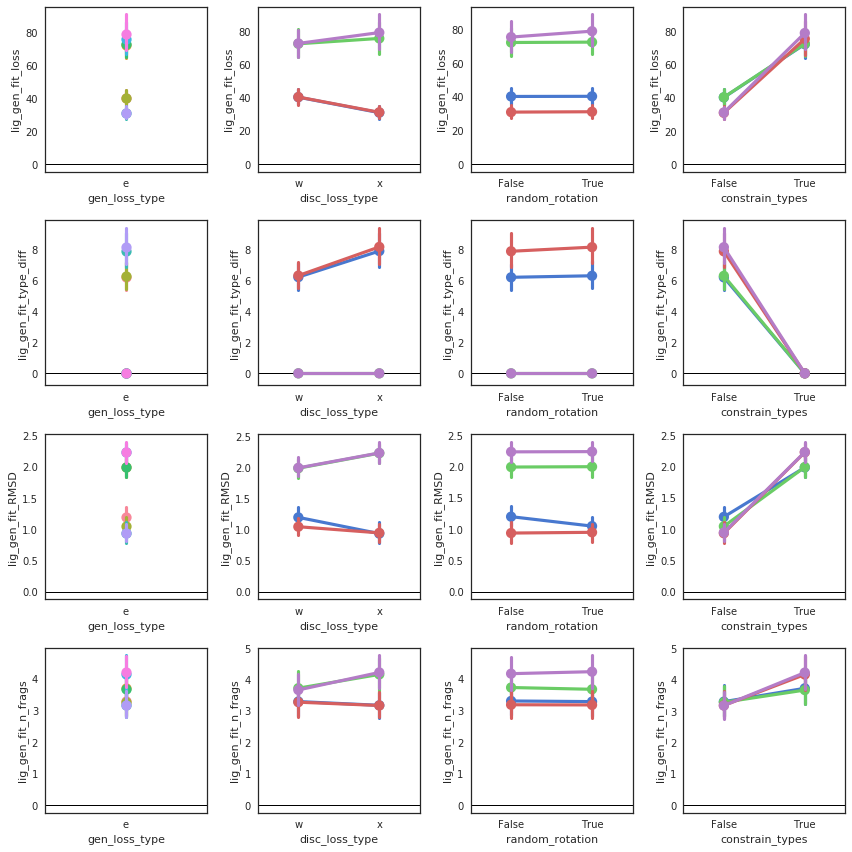

In [15]:
from results import aggregate_data, add_group_column, plot_strips

params = ['gen_loss_type', 'disc_loss_type', 'random_rotation', 'constrain_types']

plot_df = aggregate_data(fit_df, params+['lig_name']).reset_index()

for p in params:
    add_group_column(plot_df, [c for c in params if c != p])

metrics = [
    'lig_fit_time',
    'lig_gen_fit_time',
    'lig_fit_loss',
    'lig_gen_fit_loss',
    'lig_fit_type_diff',
    'lig_gen_fit_type_diff',
    'lig_fit_RMSD',
    'lig_gen_fit_RMSD',
    'lig_fit_n_frags',
    'lig_gen_fit_n_frags'
]

metrics = [
    'lig_gen_fit_loss',
    'lig_gen_fit_type_diff',
    'lig_gen_fit_RMSD',
    'lig_gen_fit_n_frags'
]


fig = plot_strips('fit_pdbbind_strips.png', plot_df[plot_df['gen_loss_type'] == 'e'], x=params, y=metrics, grouped=True,
                  n_cols=4, height=3, width=3, point=True)


In [18]:
print(plot_df.columns)

Index(['gen_loss_type', 'disc_loss_type', 'random_rotation', 'constrain_types',
       'lig_name', 'sample_idx', 'lig_norm', 'lig_gen_norm', 'lig_gen_loss',
       'lig_var', 'lig_gen_var', 'lig_fit_loss', 'lig_gen_fit_loss',
       'lig_n_atoms', 'lig_fit_n_atoms', 'lig_gen_fit_n_atoms', 'lig_radius',
       'lig_fit_radius', 'lig_gen_fit_radius', 'lig_fit_type_diff',
       'lig_gen_fit_type_diff', 'lig_fit_RMSD', 'lig_gen_fit_RMSD',
       'lig_fit_time', 'lig_gen_fit_time', 'lig_fit_error',
       'lig_gen_fit_error', 'lig_fit_n_frags', 'lig_gen_fit_n_frags',
       'expt_name', 'job_name', 'job_id', 'random_seed', 'iteration',
       '(disc_loss_type, random_rotation, constrain_types)',
       '(gen_loss_type, random_rotation, constrain_types)',
       '(gen_loss_type, disc_loss_type, constrain_types)',
       '(gen_loss_type, disc_loss_type, random_rotation)'],
      dtype='object')


/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


blue = WGAN, green = GAN


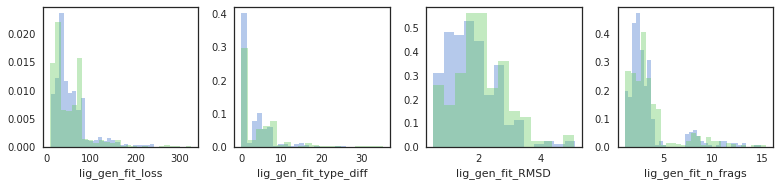

In [24]:
from results import plot_dist

fig = plot_dist('fit_pdbbind_dist.png', plot_df[(plot_df['gen_loss_type'] == 'e')], x=metrics, hue='disc_loss_type', height=2.75, width=2.75, n_cols=5, kde=False)
print('blue = WGAN, green = GAN')

/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


blue = constrained, green = unconstrained


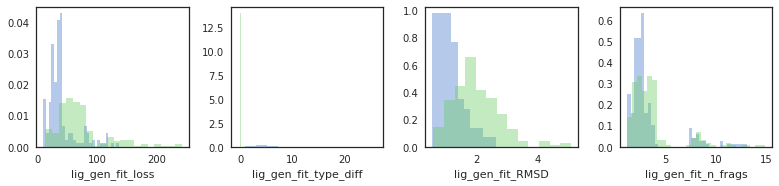

In [25]:
from results import plot_dist

fig = plot_dist('fit_pdbbind_dist.png', plot_df[(plot_df['gen_loss_type'] == 'e') & (plot_df['disc_loss_type'] == 'w')], x=metrics, hue='constrain_types', height=2.75, width=2.75, n_cols=5, kde=False)
print('blue = constrained, green = unconstrained')

/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


blue = no random rotation, green = random rotation


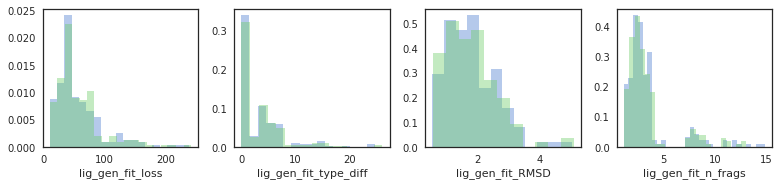

In [26]:
fig = plot_dist('fit_pdbbind_dist.png', plot_df[(plot_df['gen_loss_type'] == 'e') & (plot_df['disc_loss_type'] == 'w')], x=metrics, hue='random_rotation', height=2.75, width=2.75, n_cols=5, kde=False)
print('blue = no random rotation, green = random rotation')